In [2]:
# ! pip install torch-geometric

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.2 MB/s eta 0:00:0000:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.6/455.6 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 515.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 27.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 42.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 112.3 kB/s eta 0:00:00 0:00:01


In [101]:
#! pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl (294 kB)


In [9]:
import torch
import shap
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from torch_geometric.data import Data


In [10]:
print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Apple Silicon GPU) available: {torch.backends.mps.is_available()}")
# Check if your current device is using MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

x = torch.ones(5, device=device)
print(x)

PyTorch version: 2.0.0
MPS (Apple Silicon GPU) available: True
Using MPS device
tensor([1., 1., 1., 1., 1.], device='mps:0')


In [16]:
flow_data = pd.read_csv('OD_flow_2011_travel_time2.csv')  # Origin-Destination flows (edges)
print("Original flow data shape:", flow_data.shape)
flow_data = flow_data.dropna(subset=['origin', 'destination'])  # Remove rows with NaN values
#flow_data = flow_data.loc[ flow_data['origin'] != flow_data['destination'] ]
print("Flow data shape after dropping NaNs:", flow_data.shape)

unique_origins = flow_data['origin'].unique()
unique_destinations = flow_data['destination'].unique()
unique_areas = np.unique(np.concatenate([unique_origins, unique_destinations]))
print("Number of unique areas:", len(unique_areas))

# Read combined socioeconomic attributes
combined_gdf = pd.read_csv('combined_gdf_gnn.csv')
attri_df = combined_gdf[combined_gdf['LAD24CD'].isin(unique_areas)]
print("Filtered node attribute data shape:", attri_df.shape)

attri_df = attri_df.sort_values(by='LAD24CD').reset_index(drop=True)

# Create a mapping from area code to a node index (0, 1, ..., n-1)
area_to_index = {area: idx for idx, area in enumerate(attri_df['LAD24CD'])}

# Apply to create OD matrix with numbers
# flow_data['origin']       = flow_data['origin'].map( area_to_index)
# flow_data['destination']  = flow_data['destination'].map( area_to_index)
# attri_df['LAD24CD']     = attri_df['LAD24CD'].map( area_to_index)

flow_data['duration_in_traffic'] = flow_data['duration_in_traffic'].fillna( flow_data['duration_seconds'])

print( flow_data.isna().sum() )


Original flow data shape: (103982, 25)
Flow data shape after dropping NaNs: (103982, 25)
Number of unique areas: 348
Filtered node attribute data shape: (348, 21)
origin                 0
destination            0
On foot                0
Bicycle                0
Car_Driver             0
Rail                   0
Bus                    0
Car_Passenger          0
WfH                    0
Other                  0
Total                  0
origin_code            0
origin_long            0
origin_lat             0
workplace_code         0
workplace_long         0
workplace_lat          0
distance_km            0
log_orig_pop           0
log_dest_pop           0
log_distance           0
pred_flow              0
distance_meters        0
duration_seconds       0
duration_in_traffic    0
dtype: int64


In [18]:
attri_df.isna().sum()

LAD24CD         0
geometry        0
LAD24NM         0
LONG            0
LAT             0
Household11     0
Household21     0
Dwelling11      0
Dwelling21      0
Population10    0
Population21    0
Rents10         0
Rents21         0
GPHI11          0
GPHI21          0
Region name     0
Empolyment10    0
Empolyment21    0
Population11    0
Rents11         0
Empolyment11    0
dtype: int64

In [19]:
# Load data
node_cols = ['Household11', 'Dwelling11', 'GPHI11', 'Population11', 'Rents11', 'Empolyment11']
node_features = attri_df[node_cols].values

node_scaler = StandardScaler()
node_features_scaled = node_scaler.fit_transform(node_features)
print(node_features_scaled)
# Convert to tensor
x = torch.tensor(node_features_scaled, dtype=torch.float)


[[-0.43735527 -0.67694833 -0.78674007 -0.48350088 -0.63321138 -0.56882607]
 [-0.12141386 -0.32866609 -0.94358941 -0.17684184 -0.52385489 -0.20344217]
 [-0.07366965 -0.29076352 -0.80204244 -0.20803269 -0.50971193 -0.37578769]
 ...
 [-1.20141477 -0.26060533 -0.70090331 -0.26159734 -0.97789749 -0.74261517]
 [-1.20141477 -0.26058583 -0.43717645 -0.36168221 -0.98716774 -0.80864156]
 [-1.20141477 -0.98627462 -0.90222518 -0.75644349 -1.13427475 -1.15052442]]


In [20]:
ODflows = flow_data[["origin", "destination", 
                     "Total", "distance_meters", 
                     "duration_seconds", "duration_in_traffic",
                     "origin_long", "origin_lat", 
                     "workplace_long", "workplace_lat"]]

ODflows.columns = [ "origin", "destination", 
                   "flow", "distance", 
                     "duration", "duration_traffic",
                   "origin_lon", "origin_lat", 
                   "dest_lon", "dest_lat" ]

ODflows.head()


,origin,destination,flow,distance,duration,duration_traffic,origin_lon,origin_lat,dest_lon,dest_lat
0,E06000001,E06000001,20777,0.0,0.0,0.0,-1.27017,54.67613,-1.27017,54.67613
1,E06000001,E06000002,1591,26902.0,1369.0,1462.0,-1.27017,54.67613,-1.21099,54.54467
2,E06000001,E06000003,534,41816.0,1939.0,2049.0,-1.27017,54.67613,-1.00656,54.56752
3,E06000001,E06000004,3865,19642.0,1066.0,1153.0,-1.27017,54.67613,-1.30664,54.55687
4,E06000001,E06000005,433,37449.0,1966.0,2005.0,-1.27017,54.67613,-1.56835,54.53534


In [156]:
# # Method 1: Using pivot_table
# def create_od_matrix(df, origin_col='origin', dest_col='destination', flow_col='flow'):
#     """
#     Convert O-D DataFrame to matrix format
    
#     Parameters:
#     -----------
#     df : DataFrame with columns for origin, destination and flow
#     origin_col : name of origin column
#     dest_col : name of destination column
#     flow_col : name of flow value column
    
#     Returns:
#     --------
#     DataFrame : O-D matrix where index=origins and columns=destinations
#     """
#     # Create the O-D matrix
#     od_matrix = df.pivot_table(
#         values=flow_col,
#         index=origin_col,
#         columns=dest_col,
#         fill_value=0
#     )
    
#     # Ensure all areas appear as both origins and destinations
#     all_areas = sorted(set(df[origin_col].unique()) | set(df[dest_col].unique()))
#     for area in all_areas:
#         if area not in od_matrix.index:
#             od_matrix.loc[area] = 0
#         if area not in od_matrix.columns:
#             od_matrix[area] = 0
            
#     # Sort index and columns
#     od_matrix = od_matrix.reindex(index=all_areas, columns=all_areas, fill_value=0)
    
#     return od_matrix

# # Create O-D matrix
# od_matrix = create_od_matrix(ODflows)

# # Save to CSV
# #od_matrix.to_csv('od_matrix_2011_lad.csv')

# # Print sample of matrix
# print("Shape of O-D matrix:", od_matrix.shape)
# print("\nSample of O-D matrix:")
# print(od_matrix.iloc[:5, :5])

# # Verify total flows match
# print("\nTotal flows in original data:", ODflows['flow'].sum())
# print("Total flows in matrix:", od_matrix.values.sum())

Shape of O-D matrix: (341, 341)

Sample of O-D matrix:
destination        0        1        2        3        4
origin                                                  
0            20777.0   1591.0    534.0   3865.0    433.0
1              990.0  25474.0   5111.0   8889.0   1030.0
2              558.0  10569.0  25106.0   5387.0    682.0
3             2590.0  10779.0   3652.0  44337.0   3317.0
4              266.0   1300.0    467.0   3014.0  26671.0

Total flows in original data: 23478851
Total flows in matrix: 21770731.29478763


In [21]:
# Prepare edge features

# Assume the flow data has columns "travel_time" and "travel_distance"
edge_features = ODflows[['duration_traffic', 'distance']].values
edge_scaler = StandardScaler()
edge_features_scaled = edge_scaler.fit_transform(edge_features)
# Convert to torch tensor (shape: [num_edges, edge_feature_dim])
edge_attr = torch.tensor(edge_features_scaled, dtype=torch.float)


In [22]:
edge_features


array([[    0.,     0.],
       [ 1462., 26902.],
       [ 2049., 41816.],
       ...,
       [ 3061., 62845.],
       [ 5453., 96909.],
       [    0.,     0.]])

In [23]:
# --- Process Target Flow Values ---
flow_scaler = StandardScaler()
flow_values = ODflows['flow'].values.reshape(-1, 1)

flow_values_scaled = flow_scaler.fit_transform(flow_values)
# Convert to tensor (shape: [num_edges])
y = torch.tensor(flow_values_scaled, dtype=torch.float).squeeze()


In [24]:
# --- Build the Edge Index ---
# Map each flow's origin and destination to the corresponding node indices.
edge_index_list = [[], []]
for _, row in flow_data.iterrows():
    origin = row['origin']
    destination = row['destination']
    if origin in area_to_index and destination in area_to_index:
        edge_index_list[0].append(area_to_index[origin])
        edge_index_list[1].append(area_to_index[destination])

# Convert to a torch tensor (shape: [2, num_edges])
edge_index = torch.tensor(edge_index_list, dtype=torch.long)


In [25]:
def augment_flow_data(data):
    """Augment flow data with simple transformations"""
    # 1. Add random noise to node features
    noise = torch.randn_like(data.x) * 0.01
    data.x = data.x + noise
    # 2. Symmetric augmentation
    # If (i,j) is a valid flow, (j,i) should also be considered
    reverse_edges = torch.stack([data.edge_index[1], data.edge_index[0]], dim=0)
    data.edge_index = torch.cat([data.edge_index, reverse_edges], dim=1)
    data.y = torch.cat([data.y, data.y])
    return data

In [26]:
import os
import torch
import joblib
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv
from torch_geometric.data import Data
import copy 
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Node features shape: (348, 6)
Edge index shape: torch.Size([2, 103982])
Flow values shape: torch.Size([103982])
Data object summary:
Data(x=[348, 6], edge_index=[2, 103982], edge_attr=[103982, 2], y=[103982])

Fold 1/5
Train size: 83185, Validation size: 20797
Epoch 0: Loss 0.9533, R² -0.0022
Epoch 5: Loss 0.9468, R² 0.0046
Epoch 10: Loss 0.9435, R² 0.0081
Epoch 15: Loss 0.9395, R² 0.0123
Epoch 20: Loss 0.9356, R² 0.0164
Epoch 25: Loss 0.9319, R² 0.0203
Epoch 30: Loss 0.9287, R² 0.0237
Epoch 35: Loss 0.9252, R² 0.0273
Epoch 40: Loss 0.9212, R² 0.0315
Epoch 45: Loss 0.9159, R² 0.0371
Epoch 50: Loss 0.9091, R² 0.0443
Epoch 55: Loss 0.8999, R² 0.0539
Epoch 60: Loss 0.8879, R² 0.0666
Epoch 65: Loss 0.8711, R² 0.0842
Epoch 70: Loss 0.8465, R² 0.1101
Epoch 75: Loss 0.8119, R² 0.1465
Epoch 80: Loss 0.7618, R² 0.1991
Epoch 85: Loss 0.6967, R² 0.2676
Epoch 90: Loss 0.6150, R² 0.3534
Epoch 95: Loss 0.5304, R² 0.4424
Epoch 100: Loss 0.4644, R² 0.5118
Epoch 105: Loss 0.4266, R² 0.5515
Epoch 110: L

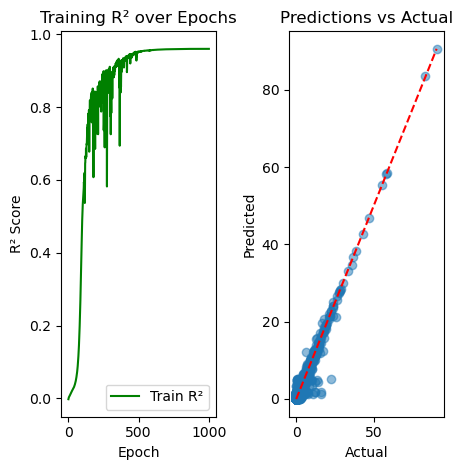


Final Metrics:
Best Loss: 0.038207
Final R²: 0.959833
Fold 1 Metrics:
Validation R²: 0.894939
Validation MSE: 0.125565
Training R²: 0.959833
Training Loss: 0.038207

Fold 2/5
Train size: 83185, Validation size: 20797
Epoch 0: Loss 0.9865, R² -0.0095
Epoch 5: Loss 0.9789, R² -0.0016
Epoch 10: Loss 0.9759, R² 0.0014
Epoch 15: Loss 0.9744, R² 0.0030
Epoch 20: Loss 0.9723, R² 0.0051
Epoch 25: Loss 0.9696, R² 0.0079
Epoch 30: Loss 0.9668, R² 0.0107
Epoch 35: Loss 0.9630, R² 0.0146
Epoch 40: Loss 0.9577, R² 0.0201
Epoch 45: Loss 0.9507, R² 0.0272
Epoch 50: Loss 0.9419, R² 0.0363
Epoch 55: Loss 0.9289, R² 0.0495
Epoch 60: Loss 0.9112, R² 0.0676
Epoch 65: Loss 0.8855, R² 0.0939
Epoch 70: Loss 0.8475, R² 0.1328
Epoch 75: Loss 0.7928, R² 0.1887
Epoch 80: Loss 0.7225, R² 0.2607
Epoch 85: Loss 0.6366, R² 0.3486
Epoch 90: Loss 0.5414, R² 0.4460
Epoch 95: Loss 0.4562, R² 0.5332
Epoch 100: Loss 0.3901, R² 0.6008
Epoch 105: Loss 0.3191, R² 0.6735
Epoch 110: Loss 0.2544, R² 0.7396
Epoch 115: Loss 0.37

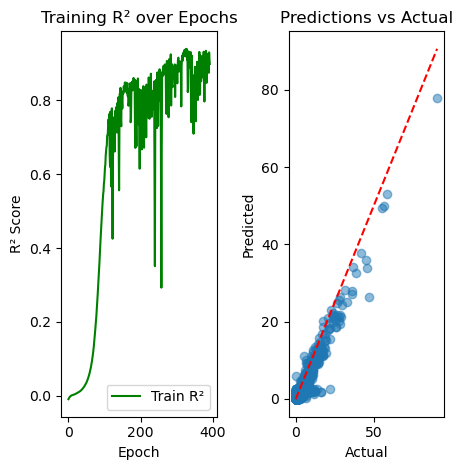


Final Metrics:
Best Loss: 0.059131
Final R²: 0.898545
Fold 2 Metrics:
Validation R²: 0.895141
Validation MSE: 0.114386
Training R²: 0.898545
Training Loss: 0.099150

Fold 3/5
Train size: 83186, Validation size: 20796
Epoch 0: Loss 0.9591, R² -0.0316
Epoch 5: Loss 0.9437, R² -0.0151
Epoch 10: Loss 0.9350, R² -0.0057
Epoch 15: Loss 0.9313, R² -0.0017
Epoch 20: Loss 0.9296, R² 0.0001
Epoch 25: Loss 0.9283, R² 0.0016
Epoch 30: Loss 0.9268, R² 0.0032
Epoch 35: Loss 0.9249, R² 0.0052
Epoch 40: Loss 0.9224, R² 0.0078
Epoch 45: Loss 0.9196, R² 0.0109
Epoch 50: Loss 0.9164, R² 0.0143
Epoch 55: Loss 0.9127, R² 0.0183
Epoch 60: Loss 0.9076, R² 0.0238
Epoch 65: Loss 0.9005, R² 0.0315
Epoch 70: Loss 0.8896, R² 0.0431
Epoch 75: Loss 0.8737, R² 0.0602
Epoch 80: Loss 0.8492, R² 0.0866
Epoch 85: Loss 0.8100, R² 0.1288
Epoch 90: Loss 0.7503, R² 0.1930
Epoch 95: Loss 0.6677, R² 0.2818
Epoch 100: Loss 0.5713, R² 0.3855
Epoch 105: Loss 0.4732, R² 0.4910
Epoch 110: Loss 0.4133, R² 0.5554
Epoch 115: Loss 0.

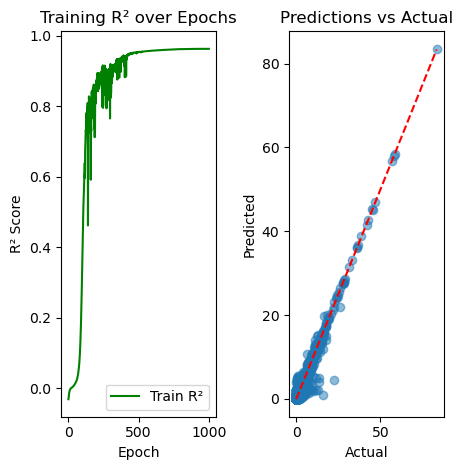


Final Metrics:
Best Loss: 0.034909
Final R²: 0.962453
Fold 3 Metrics:
Validation R²: 0.857746
Validation MSE: 0.182227
Training R²: 0.962453
Training Loss: 0.034909

Fold 4/5
Train size: 83186, Validation size: 20796
Epoch 0: Loss 1.2270, R² -0.1259
Epoch 5: Loss 1.1653, R² -0.0693
Epoch 10: Loss 1.1193, R² -0.0271
Epoch 15: Loss 1.0957, R² -0.0054
Epoch 20: Loss 1.0904, R² -0.0006
Epoch 25: Loss 1.0874, R² 0.0022
Epoch 30: Loss 1.0783, R² 0.0106
Epoch 35: Loss 1.0713, R² 0.0169
Epoch 40: Loss 1.0712, R² 0.0170
Epoch 45: Loss 1.0671, R² 0.0208
Epoch 50: Loss 1.0611, R² 0.0263
Epoch 55: Loss 1.0594, R² 0.0279
Epoch 60: Loss 1.0526, R² 0.0341
Epoch 65: Loss 1.0479, R² 0.0384
Epoch 70: Loss 1.0385, R² 0.0470
Epoch 75: Loss 1.0270, R² 0.0576
Epoch 80: Loss 1.0086, R² 0.0745
Epoch 85: Loss 0.9799, R² 0.1008
Epoch 90: Loss 0.9348, R² 0.1422
Epoch 95: Loss 0.8650, R² 0.2063
Epoch 100: Loss 0.7658, R² 0.2973
Epoch 105: Loss 0.6429, R² 0.4101
Epoch 110: Loss 0.5384, R² 0.5060
Epoch 115: Loss 0

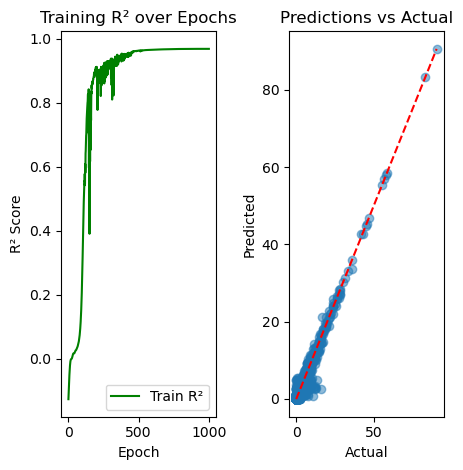


Final Metrics:
Best Loss: 0.033862
Final R²: 0.968927
Fold 4 Metrics:
Validation R²: 0.814337
Validation MSE: 0.118985
Training R²: 0.968927
Training Loss: 0.033862

Fold 5/5
Train size: 83186, Validation size: 20796
Epoch 0: Loss 1.0570, R² -0.0048
Epoch 5: Loss 1.0539, R² -0.0018
Epoch 10: Loss 1.0524, R² -0.0004
Epoch 15: Loss 1.0512, R² 0.0008
Epoch 20: Loss 1.0495, R² 0.0024
Epoch 25: Loss 1.0479, R² 0.0039
Epoch 30: Loss 1.0466, R² 0.0052
Epoch 35: Loss 1.0445, R² 0.0072
Epoch 40: Loss 1.0421, R² 0.0094
Epoch 45: Loss 1.0390, R² 0.0124
Epoch 50: Loss 1.0349, R² 0.0162
Epoch 55: Loss 1.0295, R² 0.0214
Epoch 60: Loss 1.0219, R² 0.0287
Epoch 65: Loss 1.0108, R² 0.0392
Epoch 70: Loss 0.9958, R² 0.0534
Epoch 75: Loss 0.9752, R² 0.0730
Epoch 80: Loss 0.9421, R² 0.1045
Epoch 85: Loss 0.8924, R² 0.1518
Epoch 90: Loss 0.8265, R² 0.2143
Epoch 95: Loss 0.7423, R² 0.2944
Epoch 100: Loss 0.6400, R² 0.3916
Epoch 105: Loss 0.5521, R² 0.4752
Epoch 110: Loss 0.6808, R² 0.3528
Epoch 115: Loss 0.5

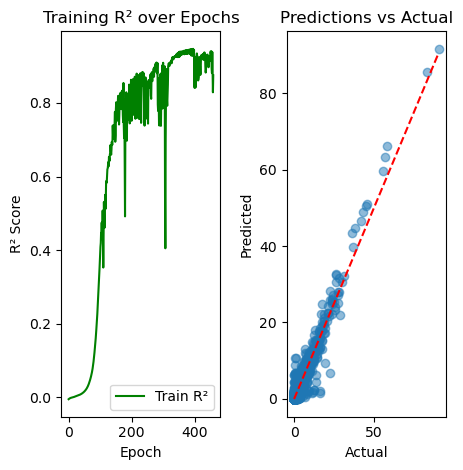


Final Metrics:
Best Loss: 0.055856
Final R²: 0.875114
Fold 5 Metrics:
Validation R²: 0.755432
Validation MSE: 0.193666
Training R²: 0.875114
Training Loss: 0.131381

Cross-validation Summary:
Mean Validation R²: 0.843519 ± 0.053145


In [27]:

# 2. Improved GNN architecture
class SmallScaleFlowPredictor(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, hidden_dim=32, output_dim=1):
        """
        Args:
            node_input_dim: Dimension of node attributes (Household11, Dwelling11, GPHI11, Population11, Rents11, Empolyment11).
            edge_input_dim: Dimension of edge attributes (travel time and distance).
            hidden_dim: Hidden dimension size (32).
            output_dim: Output dimension (e.g., 1 for flow prediction).
        """
        super( SmallScaleFlowPredictor, self).__init__()
        hidden_dim = hidden_dim if hidden_dim % 2 == 0 else hidden_dim + 1
        
        # 1. Node Feature Embedding
        self.node_embedding = nn.Sequential(
            nn.Linear(node_input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # LayerNorm better for small batches
            nn.ReLU()
        )

        # 2. Edge Feature Embedding
        self.edge_embedding = nn.Sequential(
            nn.Linear(edge_input_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU()
        )
        
        # 1. Message Passing Layers (NNConv)
        # These layers learn how nodes influence each other based on edge features
        # Edge feature transformation network
        
        # 3. Combined Edge Network
        self.edge_nn = nn.Sequential(
            nn.Linear( 2*hidden_dim + hidden_dim//2, hidden_dim ),  # Node pairs + edge features
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2)
        )
        
        # self.edge_nn = nn.Sequential(
        #     nn.Linear(2*hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim // 2)
        # )
        # 3. Flow Prediction
        self.flow_predictor = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        # 1. Embed node features
        node_embeddings = self.node_embedding(x)
        # 2. Embed edge features
        initial_edge_embeddings = self.edge_embedding(edge_attr)
        
        # 3. Get origin-destination pairs
        row, col = edge_index

        # 4. Combine origin and destination features
        # edge_features = torch.cat([
        #     node_embeddings[row],  # Origin features
        #     node_embeddings[col]   # Destination features
        # ], dim=1)

        edge_features = torch.cat([
            node_embeddings[row],      # Origin features
            node_embeddings[col],      # Destination features
            initial_edge_embeddings           # Edge features
        ], dim=1)
        
        # 5. Generate edge embeddings
        final_edge_embeddings = self.edge_nn(edge_features)
        
        # 6. Predict flows
        flows = self.flow_predictor( final_edge_embeddings )
        
        return flows
#########################################
# 3. Training the Model
#########################################

def train_model(model, data, num_epochs= 1000, patience= 64):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=0.001, 
                                  weight_decay= 0.0001)
    # Cosine warmup scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,
        epochs= num_epochs,
        steps_per_epoch=1,
        pct_start=0.3,  # Warm up for 30% of training
        div_factor=25.0,      # Initial lr = max_lr/25
        final_div_factor=1000.0  # Final lr = max_lr/25000
    )
    # Track best model
    best_loss = float('inf')
    best_model = None
    losses = []
    train_r2 = []
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        # Forward pass
        pred = model(data.x, data.edge_index, data.edge_attr)
        loss = F.mse_loss(pred.squeeze(), data.y)
        # Calculate R² score
        with torch.no_grad():
            r2 = r2_score(data.y.cpu().numpy(), 
                         pred.squeeze().cpu().numpy())
        
        # Store metrics
        losses.append(loss.item())
        train_r2.append(r2)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        # Update learning rate
        scheduler.step()
        # Save best model
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())  
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
        # Print metrics more frequently
        if epoch % 5 == 0: # Changed from 10 to 5
            print(f'Epoch {epoch}: Loss {loss.item():.4f}, R² {r2:.4f}')

    # Load the best model weights.
    model.load_state_dict(best_model)
    # Plot training metrics
    plt.subplot(1, 3, 2)
    
    plt.plot(train_r2, label='Train R²', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.title('Training R² over Epochs')
    plt.legend()
    
    # Plot predictions vs actual
    plt.subplot(1, 3, 3)
    with torch.no_grad():
        final_pred = model(data.x, data.edge_index, data.edge_attr).squeeze().cpu().numpy()
    plt.scatter(data.y.cpu().numpy(), final_pred, alpha=0.5)
    plt.plot([min(data.y.cpu().numpy()), max(data.y.cpu().numpy())], 
             [min(data.y.cpu().numpy()), max(data.y.cpu().numpy())], 
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predictions vs Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal Metrics:")
    print(f"Best Loss: {best_loss:.6f}")
    print(f"Final R²: {train_r2[-1]:.6f}")
    return model, losses, train_r2


from sklearn.model_selection import KFold
def train_with_cross_validation(model_class, data, n_splits=5, 
                                save_dir='gnn_models', **model_params):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results = []
    best_val_r2 = -float('inf')
    best_model = None
    best_fold_metrics = None
    # Create edge indices for splitting
    edge_indices = np.arange(data.edge_index.shape[1])
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(edge_indices)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print(f"Train size: {len(train_idx)}, Validation size: {len(val_idx)}")
        
        # Create train/val masks
        train_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
        train_mask[train_idx] = True
        
        # Initialize new model for this fold
        model = model_class(**model_params)
        
        # Train model
        train_data = Data(
            x = data.x,
            edge_index = data.edge_index[:, train_idx],
            edge_attr  = data.edge_attr[train_idx],
            y = data.y[train_idx]
        )
        
        model, losses, r2_scores = train_model(model, train_data)
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_data = Data(
                x=data.x,
                edge_index=data.edge_index[:, val_idx],
                edge_attr=data.edge_attr[val_idx],
                y=data.y[val_idx]
            )
            
            val_pred = model(val_data.x, 
                           val_data.edge_index, 
                           val_data.edge_attr).squeeze()
            
            val_r2 = r2_score(data.y[val_idx].cpu().numpy(), 
                         val_pred.cpu().numpy())
            val_mse = F.mse_loss(val_pred, val_data.y).item()
            
        cv_results.append({
            'fold': fold + 1,
            'val_r2': val_r2,
            'val_mse': val_mse,
            'train_r2': r2_scores[-1],
            'train_loss': losses[-1]
        })
        print(f"Fold {fold + 1} Metrics:")
        print(f"Validation R²: {val_r2:.6f}")
        print(f"Validation MSE: {val_mse:.6f}")
        print(f"Training R²: {r2_scores[-1]:.6f}")
        print(f"Training Loss: {losses[-1]:.6f}")

        # Save if this is the best model
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_model = copy.deepcopy(model)
            best_fold_metrics = {
                'fold': fold + 1,
                'val_r2': val_r2,
                'val_mse': val_mse,
                'train_r2': r2_scores[-1],
                'train_loss': losses[-1],
                'losses': losses,
                'r2_scores': r2_scores
            }
            
            # Save the model and metrics
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_params': model_params,
                'metrics': best_fold_metrics,
                'node_scaler': node_scaler,
                'edge_scaler': edge_scaler,
                'flow_scaler': flow_scaler
            }, os.path.join(save_dir, 'best_model.pt'))
    
    # Calculate and print summary statistics
    mean_val_r2 = np.mean([result['val_r2'] for result in cv_results])
    std_val_r2 = np.std([result['val_r2'] for result in cv_results])
    print("\nCross-validation Summary:")
    print(f"Mean Validation R²: {mean_val_r2:.6f} ± {std_val_r2:.6f}")
    
    # Save scalers and other necessary objects
    joblib.dump(node_scaler, os.path.join(save_dir, 'node_scaler.save'))
    joblib.dump(edge_scaler, os.path.join(save_dir, 'edge_scaler.save'))  # Add this line
    joblib.dump(flow_scaler, os.path.join(save_dir, 'flow_scaler.save'))
    
    return best_model, cv_results
# 1. First, check your input dimensions
print("Node features shape:", node_features.shape)
print("Edge index shape:", edge_index.shape)
print("Flow values shape:", y.shape)

node_features = torch.tensor(node_features_scaled, dtype=torch.float)

# Set hyperparameters.
node_input_dim = x.size(1)            # Number of node features.

# Initialize the model.
#model = FlowPredictor(node_input_dim, edge_input_dim, hidden_dim, output_dim)

# model = SmallScaleFlowPredictor(
#     node_input_dim=node_input_dim,
#     hidden_dim= hidden_dim,  # Smaller hidden dimension for small dataset
#     output_dim= output_dim
# )

# Create data object
data = Data(
    x= node_features,
    edge_index=edge_index,
    edge_attr=edge_attr,  # Add edge features
    y=y
)

# data = augment_flow_data(data)
print("Data object summary:")
print(data)

#output_model, losses, train_r2 = train_model(model, data)


model_params = {
    'node_input_dim': node_input_dim,
    'edge_input_dim': edge_features_scaled.shape[1],  # Number of edge features
    'hidden_dim': 32,
    'output_dim': 1
}

best_model, cv_results = train_with_cross_validation(SmallScaleFlowPredictor, 
                                                     data, 
                                                     n_splits=5, 
                                                     save_dir='flow_model',
                                                     **model_params)


In [28]:
cv_results

[{'fold': 1,
  'val_r2': 0.8949385298965871,
  'val_mse': 0.12556548416614532,
  'train_r2': 0.9598327984907327,
  'train_loss': 0.03820688650012016},
 {'fold': 2,
  'val_r2': 0.8951408314232093,
  'val_mse': 0.11438614875078201,
  'train_r2': 0.8985454192354464,
  'train_loss': 0.09915001690387726},
 {'fold': 3,
  'val_r2': 0.8577464769554473,
  'val_mse': 0.1822272688150406,
  'train_r2': 0.9624525023883164,
  'train_loss': 0.03490878641605377},
 {'fold': 4,
  'val_r2': 0.8143369479088136,
  'val_mse': 0.11898487061262131,
  'train_r2': 0.9689274300091684,
  'train_loss': 0.03386205807328224},
 {'fold': 5,
  'val_r2': 0.7554322767601828,
  'val_mse': 0.1936662346124649,
  'train_r2': 0.8751142743090885,
  'train_loss': 0.13138072192668915}]

Epoch 0: Loss 1.000751, R² -0.000751
Epoch 50: Loss 0.941316, R² 0.058684
Epoch 100: Loss 0.429866, R² 0.570134
Epoch 150: Loss 0.195860, R² 0.804140
Epoch 200: Loss 0.128238, R² 0.871762
Epoch 250: Loss 0.220109, R² 0.779891
Epoch 300: Loss 0.091283, R² 0.908717
Epoch 350: Loss 0.077437, R² 0.922563
Epoch 400: Loss 0.050174, R² 0.949826
Epoch 450: Loss 0.046213, R² 0.953787
Epoch 500: Loss 0.044469, R² 0.955531
Epoch 550: Loss 0.043363, R² 0.956637
Epoch 600: Loss 0.040714, R² 0.959286
Epoch 650: Loss 0.039262, R² 0.960738
Epoch 700: Loss 0.038372, R² 0.961628
Epoch 750: Loss 0.037783, R² 0.962217
Epoch 800: Loss 0.037383, R² 0.962617
Epoch 850: Loss 0.037125, R² 0.962875
Epoch 900: Loss 0.036989, R² 0.963011
Epoch 950: Loss 0.036939, R² 0.963061


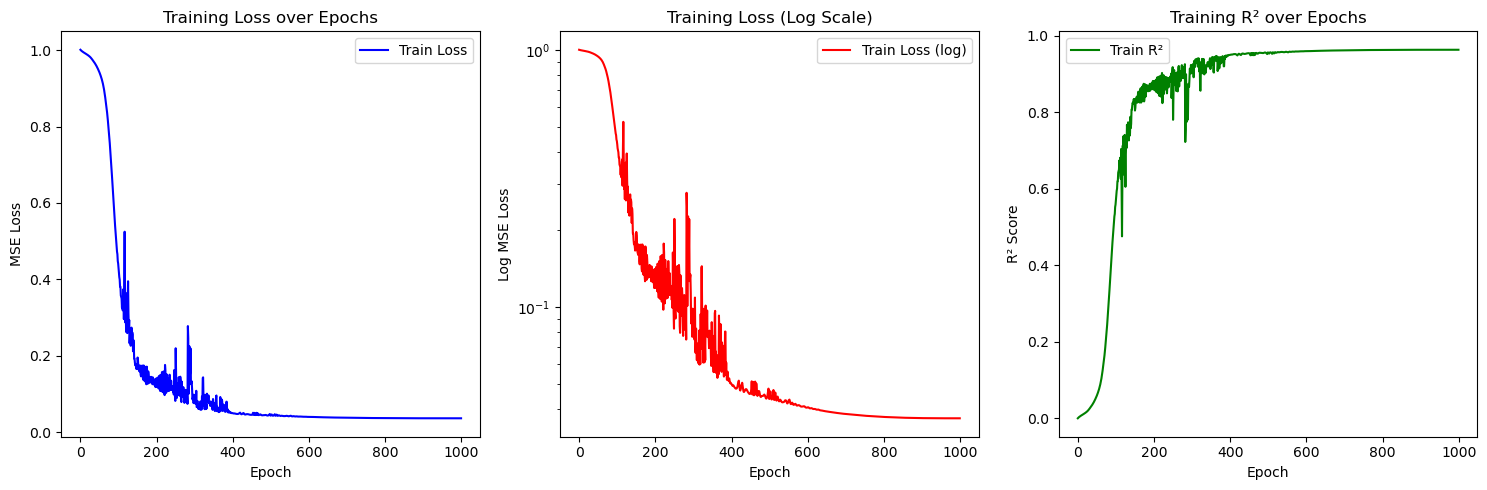

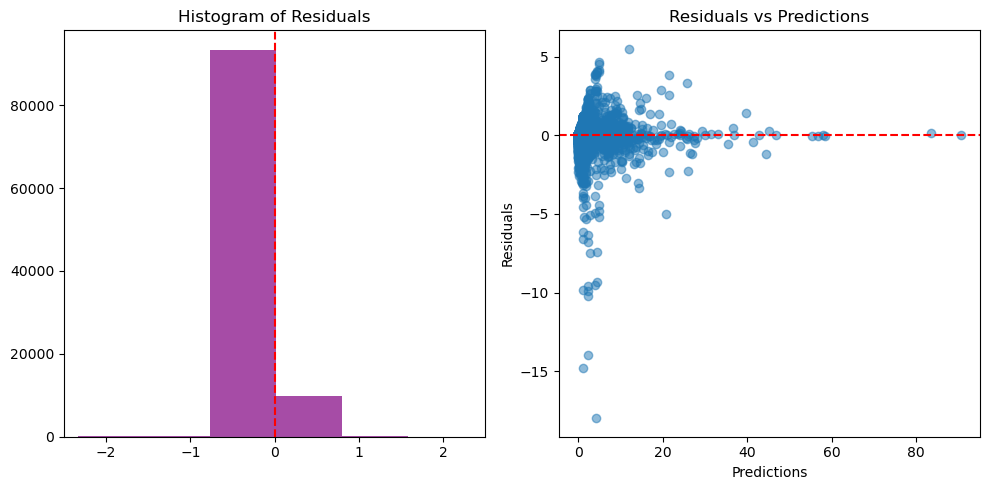

MSE: 0.036931
R²: 0.963069


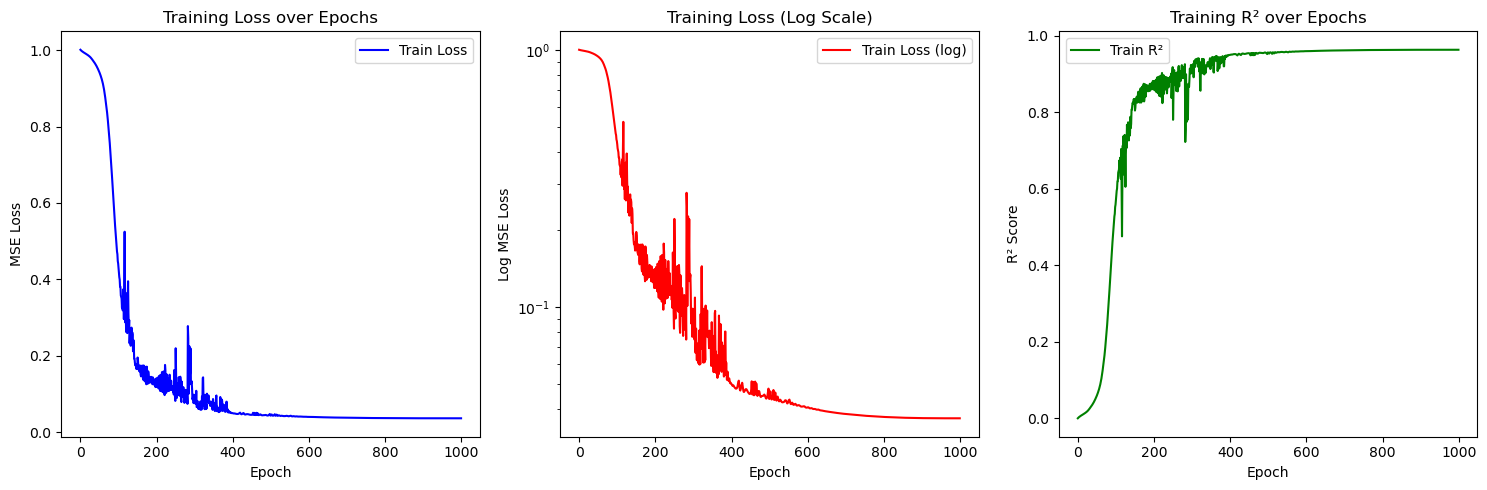

In [29]:

def plot_training_metrics(losses, train_r2):
    plt.figure(figsize=(15, 5))
    
    # Plot the training loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    
    # Plot the training loss with log scale
    plt.subplot(1, 3, 2)
    plt.semilogy(losses, label='Train Loss (log)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Log MSE Loss')
    plt.title('Training Loss (Log Scale)')
    plt.legend()
    
    # Plot the R² score
    plt.subplot(1, 3, 3)
    plt.plot(train_r2, label='Train R²', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.title('Training R² over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index, data.edge_attr).squeeze().cpu().numpy()
        true = data.y.cpu().numpy()
        
    plt.figure(figsize=(10, 5))
    residuals = pred - true
    # Scatter plot
    plt.subplot(1, 2, 1)
    #plt.scatter(true, pred, alpha=0.5)
    #plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
    plt.hist(residuals, bins=30, alpha=0.7, color='purple')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlim(-2.5, 2.5 )  # Dynamic limit based on data

    
    
    #plt.xlabel('True Values')
    #plt.ylabel('Predictions')
    plt.title('Histogram of Residuals')
    
    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = pred - true
    plt.scatter(pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predictions')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"MSE: {mse:.6f}")
    print(f"R²: {r2:.6f}")

# When training the model:
def train_with_metrics(model, data, num_epochs=1000, patience=50):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=0.001, 
                                weight_decay=0.0001)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,
        epochs=num_epochs,
        steps_per_epoch=1,
        pct_start=0.3
    )
    
    losses = []
    train_r2 = []
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        pred = model(data.x, data.edge_index, data.edge_attr)
        loss = F.mse_loss(pred.squeeze(), data.y)
        
        with torch.no_grad():
            r2 = r2_score(data.y.cpu().numpy(), 
                         pred.squeeze().cpu().numpy())
        
        losses.append(loss.item())
        train_r2.append(r2)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
            
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss {loss.item():.6f}, R² {r2:.6f}')
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Plot metrics
    plot_training_metrics(losses, train_r2)
    plot_predictions(model, data)
    
    return model, losses, train_r2

# Usage:
model = SmallScaleFlowPredictor(
    node_input_dim=node_input_dim,
    edge_input_dim=edge_features_scaled.shape[1],
    hidden_dim=32,
    output_dim=1
)

best_model, losses, train_r2 = train_with_metrics(model, data)

# Save metrics for later use
metrics = {
    'losses': losses,
    'train_r2': train_r2
}
joblib.dump(metrics, './gnn_models/train2/training_metrics.save')

# To load and plot metrics later:
def load_and_plot_metrics(metrics_path='./gnn_models/train2/training_metrics.save'):
    metrics = joblib.load(metrics_path)
    plot_training_metrics(metrics['losses'], metrics['train_r2'])

# Example usage:
load_and_plot_metrics()

In [30]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import r2_score, mean_squared_error
from torch_geometric.data import Data

def create_flow_heatmap(model, data, area_to_index, attri_df, flow_scaler, save_dir='flow_analysis'):
    """
    Generate heatmaps comparing actual vs. predicted flows
    
    Args:
        model: Trained GNN model
        data: PyG Data object with test data
        area_to_index: Dictionary mapping area codes to node indices
        attri_df: DataFrame with area information
        flow_scaler: StandardScaler for flow values
        save_dir: Directory to save outputs
    """
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        pred_scaled = model(data.x, data.edge_index, data.edge_attr).squeeze().cpu().numpy()
    
    # Inverse transform predictions to original scale
    predictions = flow_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    
    # Get actual values
    actual = flow_scaler.inverse_transform(data.y.cpu().numpy().reshape(-1, 1)).flatten()
    
    # Reverse area_to_index mapping
    index_to_area = {idx: area for area, idx in area_to_index.items()}
    
    # Extract origin-destination pairs from edge_index
    origins = [index_to_area[idx.item()] for idx in data.edge_index[0]]
    destinations = [index_to_area[idx.item()] for idx in data.edge_index[1]]
    
    # Create comparison DataFrame
    flow_df = pd.DataFrame({
        'Origin': origins,
        'Destination': destinations,
        'Actual': actual,
        'Predicted': predictions,
        'Residual': actual - predictions,
        'Error_Pct': (actual - predictions) / (actual + 1) * 100  # Add 1 to prevent division by zero
    })
    
    # Save detailed comparison
    flow_df.to_csv(os.path.join(save_dir, 'flow_predictions_comparison.csv'), index=False)
    
    # 1. Create OD matrices for actual, predicted, and residual flows
    # Get unique areas in order
    unique_areas = sorted(list(area_to_index.keys()))
    
    # Initialize matrices
    n_areas = len(unique_areas)
    actual_matrix = np.zeros((n_areas, n_areas))
    pred_matrix = np.zeros((n_areas, n_areas))
    residual_matrix = np.zeros((n_areas, n_areas))
    
    # Fill matrices
    for _, row in flow_df.iterrows():
        o_idx = unique_areas.index(row['Origin'])
        d_idx = unique_areas.index(row['Destination'])
        actual_matrix[o_idx, d_idx] = row['Actual']
        pred_matrix[o_idx, d_idx] = row['Predicted']
        residual_matrix[o_idx, d_idx] = row['Residual']
    
    # Get area names for labeling
    area_names = [attri_df[attri_df['LAD24CD'] == area]['LAD24NM'].values[0] 
                 for area in unique_areas if area in attri_df['LAD24CD'].values]
    
    # 2. Create heatmaps
    
    # a. Actual Flows
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(actual_matrix, 
                    cmap='viridis', 
                    robust=True,
                    xticklabels=area_names,
                    yticklabels=area_names)
    plt.title('Actual Travel Flows', fontsize=14)
    plt.xlabel('Destination', fontsize=12)
    plt.ylabel('Origin', fontsize=12)
    # Rotate x-axis labels for readability
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    # Adjust for better display
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'actual_flows_heatmap.png'), dpi=300)
    plt.close()
    
    # b. Predicted Flows
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(pred_matrix, 
                    cmap='viridis', 
                    robust=True,
                    xticklabels=area_names,
                    yticklabels=area_names)
    plt.title('Predicted Travel Flows', fontsize=14)
    plt.xlabel('Destination', fontsize=12)
    plt.ylabel('Origin', fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'predicted_flows_heatmap.png'), dpi=300)
    plt.close()
    
    # c. Residuals (Using diverging colormap to highlight under/over predictions)
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(residual_matrix, 
                    cmap='RdBu_r',  # Red-Blue diverging, reversed so red=underprediction
                    center=0,       # Center colormap at zero
                    robust=True,
                    xticklabels=area_names,
                    yticklabels=area_names)
    plt.title('Residual Flows (Actual - Predicted)', fontsize=14)
    plt.xlabel('Destination', fontsize=12)
    plt.ylabel('Origin', fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'residual_flows_heatmap.png'), dpi=300)
    plt.close()
    
    # 3. Scatter plot with highlighted outliers
    plt.figure(figsize=(5, 9))
    
    # Calculate error percentiles for identifying outliers
    q_low = flow_df['Error_Pct'].quantile(0.05)
    q_high = flow_df['Error_Pct'].quantile(0.95)
    
    # Main scatter
    plt.scatter(flow_df['Actual'], flow_df['Predicted'], alpha=0.5, label='All Flows')
    
    # Highlight outliers
    outliers = flow_df[(flow_df['Error_Pct'] < q_low) | (flow_df['Error_Pct'] > q_high)]
    plt.scatter(outliers['Actual'], outliers['Predicted'], color='red', alpha=0.8, label='Outliers')
    
    # Annotate significant outliers
    top_outliers = outliers.sort_values('Error_Pct', key=abs, ascending=False).head(5)
    for _, row in top_outliers.iterrows():
        o_name = attri_df[attri_df['LAD24CD'] == row['Origin']]['LAD24NM'].values[0]
        d_name = attri_df[attri_df['LAD24CD'] == row['Destination']]['LAD24NM'].values[0]
        plt.annotate(f"{o_name} → {d_name}",
                    (row['Actual'], row['Predicted']),
                    xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Add diagonal reference line (perfect prediction)
    max_val = max(flow_df['Actual'].max(), flow_df['Predicted'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', label='Perfect Prediction')
    
    plt.xlabel('Actual Flow', fontsize=12)
    plt.ylabel('Predicted Flow', fontsize=12)
    plt.title('Actual vs. Predicted Flows', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'actual_vs_predicted_scatter.png'), dpi=300)
    plt.close()
    
    # 4. Top/Bottom predictions summary table
    # Find most underpredicted and overpredicted flows
    flow_df['Error_Magnitude'] = np.abs(flow_df['Residual'])
    
    top_under = flow_df[flow_df['Residual'] > 0].sort_values('Error_Magnitude', ascending=False).head(10)
    top_over = flow_df[flow_df['Residual'] < 0].sort_values('Error_Magnitude', ascending=False).head(10)
    
    # Add area names
    def add_area_names(df):
        df = df.copy()
        df['Origin_Name'] = df['Origin'].apply(lambda x: attri_df[attri_df['LAD24CD'] == x]['LAD24NM'].values[0] 
                                              if x in attri_df['LAD24CD'].values else 'Unknown')
        df['Dest_Name'] = df['Destination'].apply(lambda x: attri_df[attri_df['LAD24CD'] == x]['LAD24NM'].values[0]
                                                 if x in attri_df['LAD24CD'].values else 'Unknown')
        return df
    
    top_under = add_area_names(top_under)
    top_over = add_area_names(top_over)
    
    # Save as CSV
    top_under.to_csv(os.path.join(save_dir, 'top_underpredicted_flows.csv'), index=False)
    top_over.to_csv(os.path.join(save_dir, 'top_overpredicted_flows.csv'), index=False)
    
    # 5. Summary statistics
    # Calculate performance metrics
    overall_r2 = r2_score(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mean_abs_err = np.mean(np.abs(flow_df['Residual']))
    median_abs_err = np.median(np.abs(flow_df['Residual']))
    
    # Save summary
    with open(os.path.join(save_dir, 'flow_prediction_summary.txt'), 'w') as f:
        f.write("Flow Prediction Performance Summary\n")
        f.write("==================================\n\n")
        f.write(f"Overall R² Score: {overall_r2:.4f}\n")
        f.write(f"RMSE: {rmse:.4f}\n")
        f.write(f"Mean Absolute Error: {mean_abs_err:.4f}\n")
        f.write(f"Median Absolute Error: {median_abs_err:.4f}\n\n")
        
        f.write("Top Underpredicted Flows:\n")
        for i, row in top_under.head(5).iterrows():
            f.write(f"  {row['Origin_Name']} → {row['Dest_Name']}: ")
            f.write(f"Actual={row['Actual']:.1f}, Predicted={row['Predicted']:.1f}, ")
            f.write(f"Error={row['Residual']:.1f} ({row['Error_Pct']:.1f}%)\n")
        
        f.write("\nTop Overpredicted Flows:\n")
        for i, row in top_over.head(5).iterrows():
            f.write(f"  {row['Origin_Name']} → {row['Dest_Name']}: ")
            f.write(f"Actual={row['Actual']:.1f}, Predicted={row['Predicted']:.1f}, ")
            f.write(f"Error={row['Residual']:.1f} ({row['Error_Pct']:.1f}%)\n")
    
    print(f"Flow analysis complete. Results saved in {save_dir}/")
    
    return actual_matrix, pred_matrix, residual_matrix, flow_df

# Example usage
def analyze_flow_predictions(best_model, data, area_to_index, attri_df, flow_scaler):
    """
    Run flow prediction analysis and generate visualizations
    """
    actual_matrix, pred_matrix, residual_matrix, flow_df = create_flow_heatmap(
        model=best_model,
        data=data,
        area_to_index=area_to_index,
        attri_df=attri_df,
        flow_scaler=flow_scaler,
        save_dir='flow_analysis'
    )
    
    # Additional analysis for PowerPoint slides
    # Display correlation between actual and predicted matrices
    correlation = np.corrcoef(actual_matrix.flatten(), pred_matrix.flatten())[0, 1]
    print(f"Correlation between actual and predicted flow matrices: {correlation:.4f}")
    
    # Calculate percentage of flows within different error margins
    within_10pct = (np.abs(flow_df['Error_Pct']) <= 10).mean() * 100
    within_25pct = (np.abs(flow_df['Error_Pct']) <= 25).mean() * 100
    within_50pct = (np.abs(flow_df['Error_Pct']) <= 50).mean() * 100
    
    print(f"Percentage of flows predicted within 10% error: {within_10pct:.1f}%")
    print(f"Percentage of flows predicted within 25% error: {within_25pct:.1f}%")
    print(f"Percentage of flows predicted within 50% error: {within_50pct:.1f}%")
    
    return flow_df

# After loading your best model
checkpoint = torch.load('flow_model/best_model.pt')
best_model = SmallScaleFlowPredictor(**checkpoint['model_params'])
best_model.load_state_dict(checkpoint['model_state_dict'])
flow_scaler = checkpoint['flow_scaler']

# Run the analysis
flow_analysis = analyze_flow_predictions(
    best_model=best_model,
    data=data,           # Your PyG data object
    area_to_index=area_to_index,  # The mapping you created earlier
    attri_df=attri_df,   # DataFrame with area information
    flow_scaler=flow_scaler
)

Flow analysis complete. Results saved in flow_analysis/
Correlation between actual and predicted flow matrices: 0.9745
Percentage of flows predicted within 10% error: 2.6%
Percentage of flows predicted within 25% error: 6.5%
Percentage of flows predicted within 50% error: 13.0%


Baseline R² score: 0.9069

Calculating node feature importance...
  Household: 0.8886 ± 0.1021
  Dwelling: 0.3823 ± 0.0228
  GPHI: 0.3580 ± 0.0803
  Population Size: 8.2553 ± 0.6336
  Rents: 0.4047 ± 0.1796
  Employment: 0.4766 ± 0.0271

Calculating edge feature importance...
  Distance: 0.7580 ± 0.0208
  Travel Time: 0.6985 ± 0.0451

Performing ablation study...
  Without Household: R² drops by 0.8227
  Without Dwelling: R² drops by 0.2350
  Without GPHI: R² drops by 0.0776
  Without Population Size: R² drops by 8.7902
  Without Rents: R² drops by 0.2470
  Without Employment: R² drops by 0.3728
  Without Distance: R² drops by 0.7863
  Without Travel Time: R² drops by 0.7623


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_65838/1132783156.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Feature', data=ablation_df,


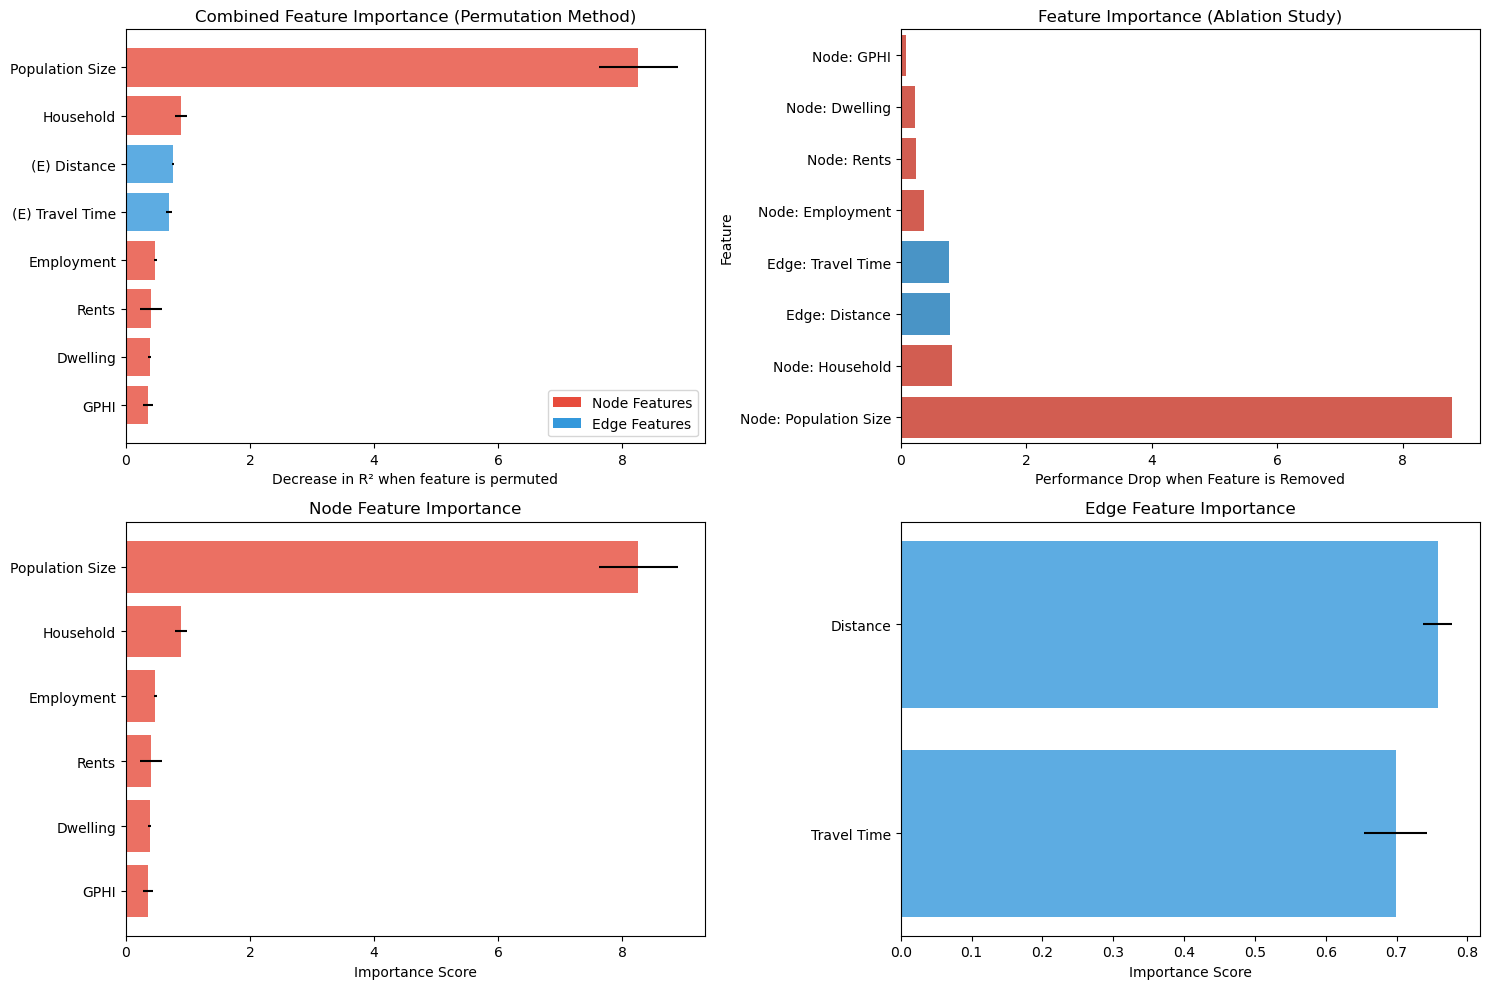

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_65838/1132783156.py:248: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Feature', data=ablation_df,


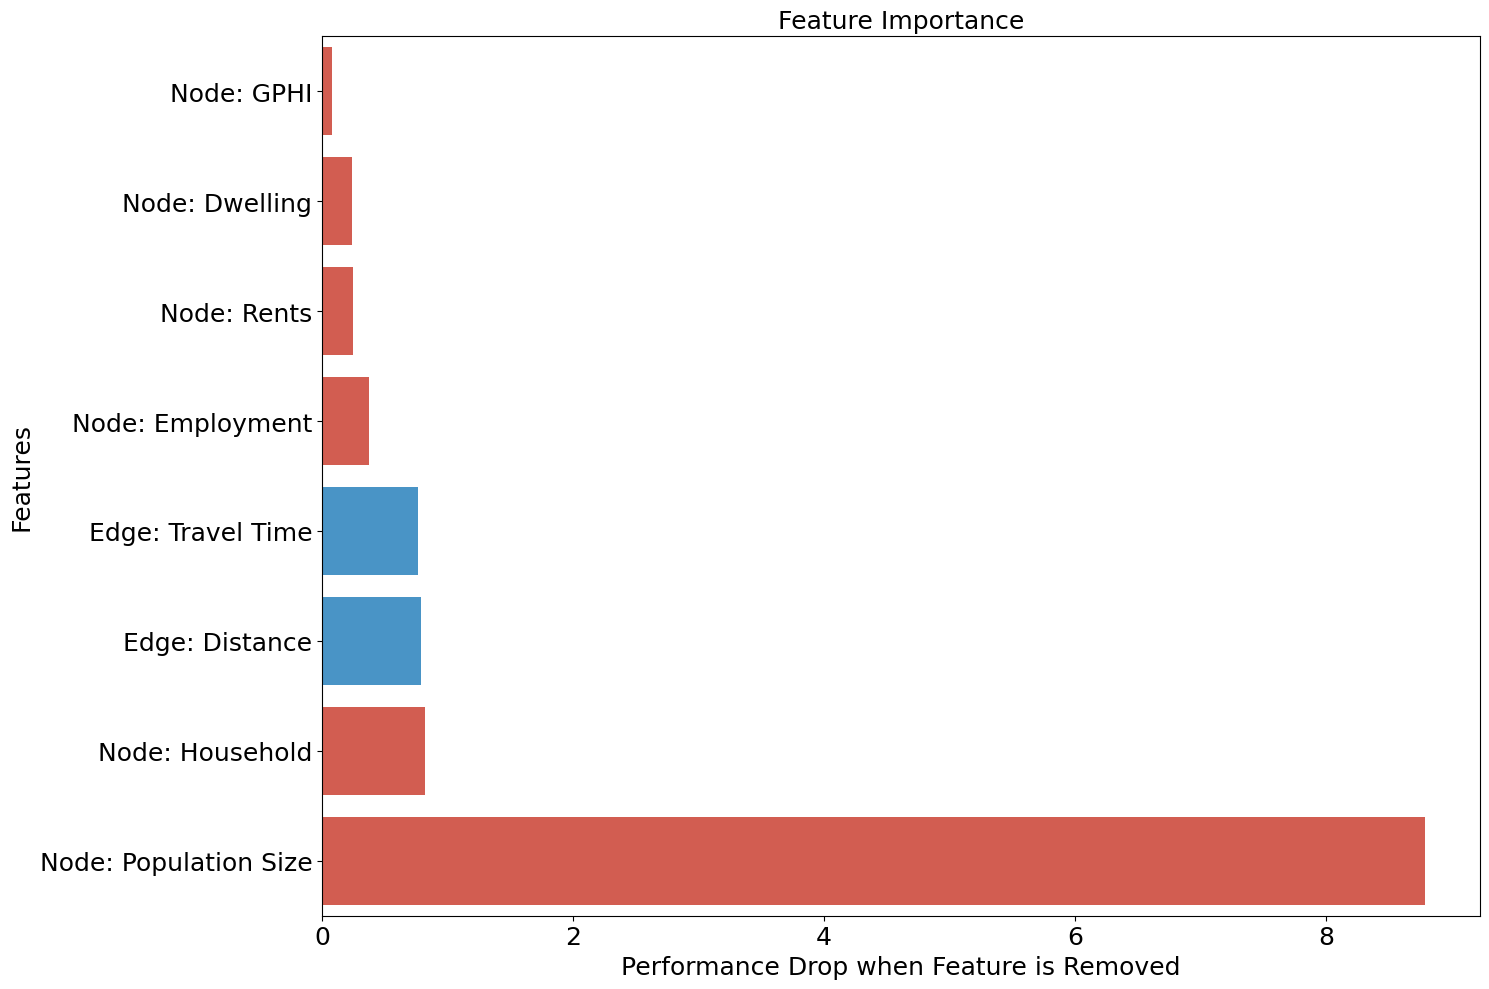


Overall Feature Importance Ranking:
           Feature  Type  Importance    StdDev  Ablation_Impact
3  Population Size  Node    8.255303  0.633631         8.790173
0        Household  Node    0.888596  0.102124         0.822709
0         Distance  Edge    0.758039  0.020763         0.786311
1      Travel Time  Edge    0.698488  0.045059         0.762302
5       Employment  Node    0.476645  0.027137         0.372833
4            Rents  Node    0.404740  0.179558         0.247047
1         Dwelling  Node    0.382312  0.022779         0.234955
2             GPHI  Node    0.358006  0.080282         0.077635


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from copy import deepcopy

def analyze_gnn_feature_importance(model, data, node_feature_names, edge_feature_names, n_repeats=5):
    """
    Comprehensive analysis of both node and edge feature importance.
    
    Args:
        model: Trained GNN model
        data: PyG Data object
        node_feature_names: List of node feature names
        edge_feature_names: List of edge feature names
        n_repeats: Number of permutation repeats for stable results
    """
    model.eval()
    
    # Get baseline performance
    with torch.no_grad():
        baseline_pred = model(data.x, data.edge_index, data.edge_attr).squeeze()
        baseline_score = r2_score(data.y.cpu().numpy(), baseline_pred.cpu().numpy())
    
    print(f"Baseline R² score: {baseline_score:.4f}")
    
    # 1. Node Feature Importance
    node_importances = np.zeros(len(node_feature_names))
    node_importances_std = np.zeros(len(node_feature_names))
    
    print("\nCalculating node feature importance...")
    for i in range(len(node_feature_names)):
        feature_scores = []
        for _ in range(n_repeats):
            # Create permuted dataset
            permuted_data = deepcopy(data)
            perm_idx = torch.randperm(data.x.shape[0])
            permuted_data.x[:, i] = data.x[perm_idx, i]
            
            # Get predictions with permuted feature
            with torch.no_grad():
                perm_pred = model(permuted_data.x, permuted_data.edge_index, 
                                 permuted_data.edge_attr).squeeze()
                perm_score = r2_score(data.y.cpu().numpy(), perm_pred.cpu().numpy())
            
            # Calculate performance drop
            feature_scores.append(baseline_score - perm_score)
        
        # Average importance over repeats
        node_importances[i] = np.mean(feature_scores)
        node_importances_std[i] = np.std(feature_scores)
        
        print(f"  {node_feature_names[i]}: {node_importances[i]:.4f} ± {node_importances_std[i]:.4f}")
    
    # 2. Edge Feature Importance
    edge_importances = np.zeros(len(edge_feature_names))
    edge_importances_std = np.zeros(len(edge_feature_names))
    
    print("\nCalculating edge feature importance...")
    for i in range(len(edge_feature_names)):
        feature_scores = []
        for _ in range(n_repeats):
            # Create permuted dataset
            permuted_data = deepcopy(data)
            perm_idx = torch.randperm(data.edge_attr.shape[0])
            permuted_data.edge_attr[:, i] = data.edge_attr[perm_idx, i]
            
            # Get predictions with permuted feature
            with torch.no_grad():
                perm_pred = model(permuted_data.x, permuted_data.edge_index, 
                                 permuted_data.edge_attr).squeeze()
                perm_score = r2_score(data.y.cpu().numpy(), perm_pred.cpu().numpy())
            
            # Calculate performance drop
            feature_scores.append(baseline_score - perm_score)
        
        # Average importance over repeats
        edge_importances[i] = np.mean(feature_scores)
        edge_importances_std[i] = np.std(feature_scores)
        
        print(f"  {edge_feature_names[i]}: {edge_importances[i]:.4f} ± {edge_importances_std[i]:.4f}")
    
    # 3. Ablation study - removing features one by one
    print("\nPerforming ablation study...")
    ablation_results = {}
    
    # Node ablation
    for i, name in enumerate(node_feature_names):
        ablated_data = deepcopy(data)
        ablated_data.x[:, i] = 0  # Zero out feature
        
        with torch.no_grad():
            abl_pred = model(ablated_data.x, ablated_data.edge_index, 
                             ablated_data.edge_attr).squeeze()
            abl_score = r2_score(data.y.cpu().numpy(), abl_pred.cpu().numpy())
        
        ablation_results[f"Node: {name}"] = baseline_score - abl_score
        print(f"  Without {name}: R² drops by {ablation_results[f'Node: {name}']:.4f}")
    
    # Edge ablation
    for i, name in enumerate(edge_feature_names):
        ablated_data = deepcopy(data)
        ablated_data.edge_attr[:, i] = 0  # Zero out feature
        
        with torch.no_grad():
            abl_pred = model(ablated_data.x, ablated_data.edge_index, 
                             ablated_data.edge_attr).squeeze()
            abl_score = r2_score(data.y.cpu().numpy(), abl_pred.cpu().numpy())
        
        ablation_results[f"Edge: {name}"] = baseline_score - abl_score
        print(f"  Without {name}: R² drops by {ablation_results[f'Edge: {name}']:.4f}")
    
    # 4. Visualize Results
    plot_node_edge_importance(node_feature_names, node_importances, node_importances_std,
                             edge_feature_names, edge_importances, edge_importances_std,
                             ablation_results)
    
    plot_node_edge_importance2(node_feature_names, node_importances, node_importances_std,
                             edge_feature_names, edge_importances, edge_importances_std,
                             ablation_results)

    # Return results in DataFrame format
    node_results = pd.DataFrame({
        'Feature': node_feature_names,
        'Type': 'Node',
        'Importance': node_importances,
        'StdDev': node_importances_std,
        'Ablation_Impact': [ablation_results[f"Node: {name}"] for name in node_feature_names]
    })
    
    edge_results = pd.DataFrame({
        'Feature': edge_feature_names,
        'Type': 'Edge',
        'Importance': edge_importances,
        'StdDev': edge_importances_std,
        'Ablation_Impact': [ablation_results[f"Edge: {name}"] for name in edge_feature_names]
    })
    
    feature_importance = pd.concat([node_results, edge_results]).sort_values('Importance', ascending=False)
    
    return feature_importance

def plot_node_edge_importance(node_names, node_imp, node_std, 
                             edge_names, edge_imp, edge_std,
                             ablation_results):
    """
    Plot comprehensive visualization of feature importance
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Combined permutation importance with node/edge distinction
    plt.subplot(2, 2, 1)
    
    # Combine data
    all_names = np.concatenate([node_names, [f"(E) {name}" for name in edge_names]])
    all_imp = np.concatenate([node_imp, edge_imp])
    all_std = np.concatenate([node_std, edge_std])
    
    # Sort by importance
    sort_idx = np.argsort(all_imp)
    sorted_names = all_names[sort_idx]
    sorted_imp = all_imp[sort_idx]
    sorted_std = all_std[sort_idx]
    
    # Color bars by feature type
    colors = ['#3498db' if '(E)' in name else '#e74c3c' for name in sorted_names]
    
    plt.barh(range(len(sorted_names)), sorted_imp, xerr=sorted_std, 
             align='center', alpha=0.8, color=colors)
    
    plt.yticks(range(len(sorted_names)), sorted_names)
    plt.xlabel('Decrease in R² when feature is permuted')
    plt.title('Combined Feature Importance (Permutation Method)')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', label='Node Features'),
        Patch(facecolor='#3498db', label='Edge Features')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    # 2. Ablation results
    plt.subplot(2, 2, 2)
    ablation_df = pd.DataFrame({
        'Feature': list(ablation_results.keys()),
        'Impact': list(ablation_results.values())
    }).sort_values('Impact')
    
    sns.barplot(x='Impact', y='Feature', data=ablation_df, 
                palette=['#3498db' if 'Edge' in f else '#e74c3c' for f in ablation_df['Feature']])
    
    plt.xlabel('Performance Drop when Feature is Removed')
    plt.title('Feature Importance (Ablation Study)')
    
    # 3. Node features only - more detailed
    plt.subplot(2, 2, 3)
    
    # Sort node features
    node_idx = np.argsort(node_imp)
    plt.barh(range(len(node_names)), node_imp[node_idx], xerr=node_std[node_idx],
             align='center', alpha=0.8, color='#e74c3c')
    
    plt.yticks(range(len(node_names)), [node_names[i] for i in node_idx])
    plt.xlabel('Importance Score')
    plt.title('Node Feature Importance')
    
    # 4. Edge features only - more detailed
    plt.subplot(2, 2, 4)
    
    # Sort edge features
    edge_idx = np.argsort(edge_imp)
    plt.barh(range(len(edge_names)), edge_imp[edge_idx], xerr=edge_std[edge_idx],
             align='center', alpha=0.8, color='#3498db')
    
    plt.yticks(range(len(edge_names)), [edge_names[i] for i in edge_idx])
    plt.xlabel('Importance Score')
    plt.title('Edge Feature Importance')
    
    plt.tight_layout()
    plt.show()


def plot_node_edge_importance2(node_names, node_imp, node_std, 
                             edge_names, edge_imp, edge_std,
                             ablation_results):
    all_names = np.concatenate([node_names, [f"(E) {name}" for name in edge_names]])
    all_imp = np.concatenate([node_imp, edge_imp])
    all_std = np.concatenate([node_std, edge_std])
    
    # Sort by importance
    sort_idx = np.argsort(all_imp)
    sorted_names = all_names[sort_idx]
    sorted_imp = all_imp[sort_idx]
    sorted_std = all_std[sort_idx]
    
    # Color bars by feature type
    colors = ['#3498db' if '(E)' in name else '#e74c3c' for name in sorted_names]
    
    plt.figure(figsize=(15, 10))
    ablation_df = pd.DataFrame({
        'Feature': list(ablation_results.keys()),
        'Impact': list(ablation_results.values())
    }).sort_values('Impact')
    
    sns.barplot(x='Impact', y='Feature', data=ablation_df, 
                palette=['#3498db' if 'Edge' in f else '#e74c3c' for f in ablation_df['Feature']])
    
    plt.xlabel('Performance Drop when Feature is Removed', fontsize = 18)
    plt.ylabel('Features', fontsize=18)
    plt.title('Feature Importance', fontsize = 18)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.tight_layout()
    plt.show()

# Example usage
def run_feature_importance_analysis(best_model, data):
    # Define feature names for your model
    node_feature_names = ['Household', 'Dwelling', 'GPHI', 
                        'Population Size', 'Rents', 'Employment']
    
    edge_feature_names = ['Distance', 'Travel Time']  # Adjust based on your edge features
    
    # Run analysis
    importance_results = analyze_gnn_feature_importance(
        model=best_model,
        data=data,
        node_feature_names=node_feature_names,
        edge_feature_names=edge_feature_names,
        n_repeats=5  # Increase for more stable results
    )
    
    print("\nOverall Feature Importance Ranking:")
    print(importance_results)
    
    return importance_results


Baseline R² score: 0.9069

Calculating node feature importance...
  Household: 0.9886 ± 0.0459
  Dwelling: 0.3544 ± 0.0227
  GPHI: 0.3340 ± 0.1536
  Population Size: 8.0406 ± 0.4905
  Rents: 0.3143 ± 0.1009
  Employment: 0.4608 ± 0.0128

Calculating edge feature importance...
  Distance: 0.7695 ± 0.0144
  Travel Time: 0.6673 ± 0.0159

Performing ablation study...
  Without Household: R² drops by 0.8227
  Without Dwelling: R² drops by 0.2350
  Without GPHI: R² drops by 0.0776
  Without Population Size: R² drops by 8.7902
  Without Rents: R² drops by 0.2470
  Without Employment: R² drops by 0.3728
  Without Distance: R² drops by 0.7863
  Without Travel Time: R² drops by 0.7623


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_65838/1132783156.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Feature', data=ablation_df,


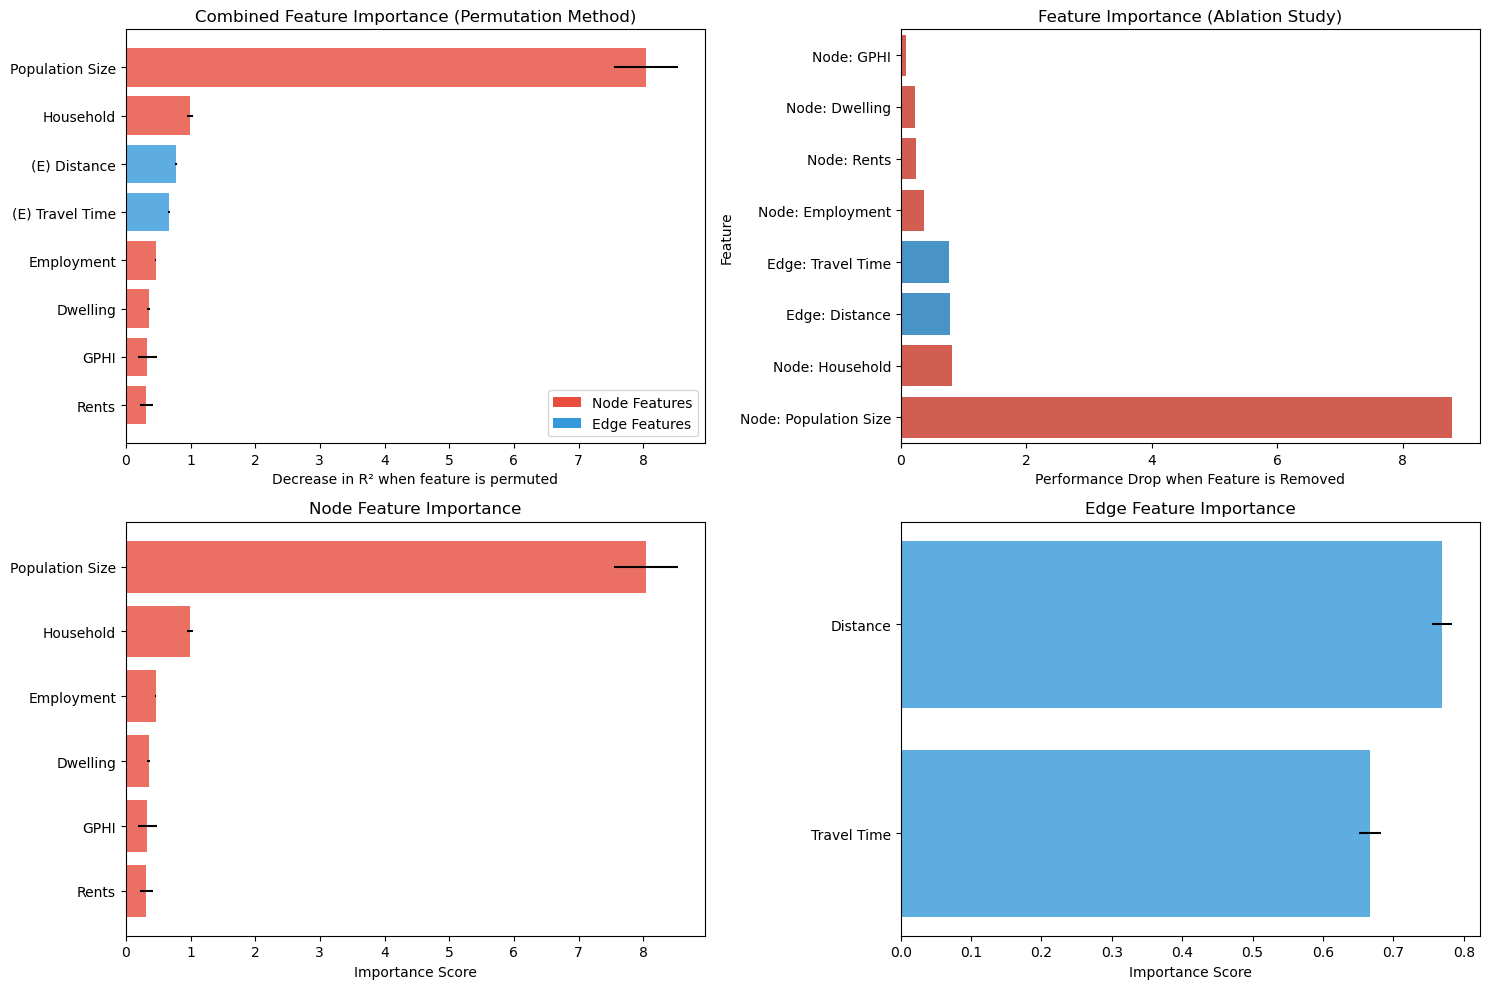

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_65838/1132783156.py:248: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Feature', data=ablation_df,


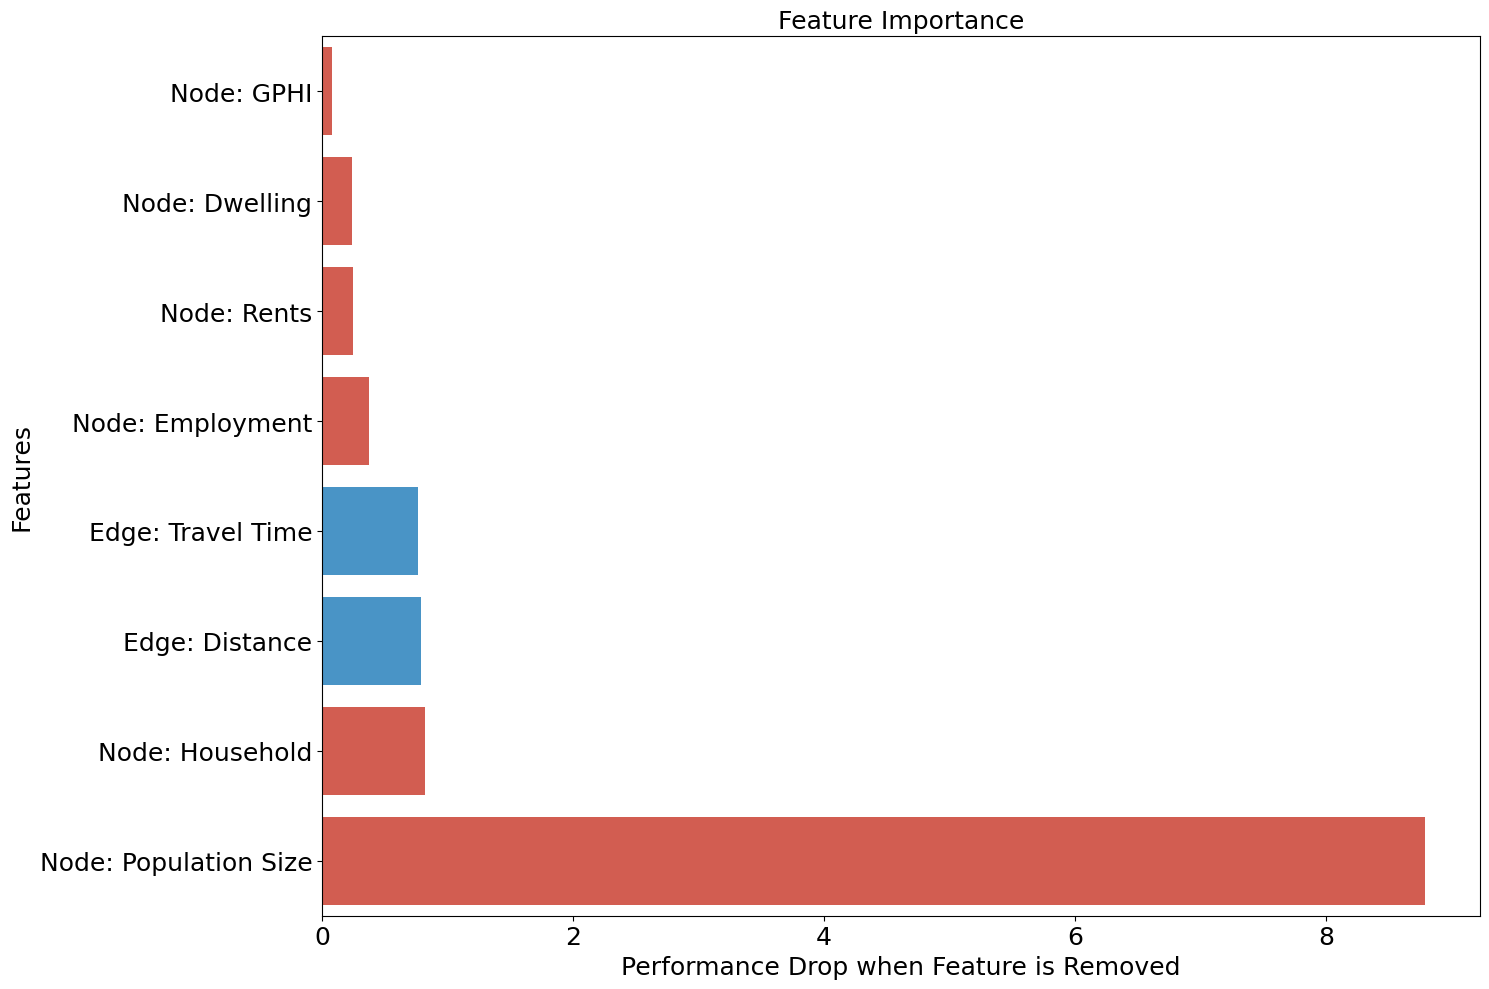


Overall Feature Importance Ranking:
           Feature  Type  Importance    StdDev  Ablation_Impact
3  Population Size  Node    8.040623  0.490467         8.790173
0        Household  Node    0.988577  0.045884         0.822709
0         Distance  Edge    0.769504  0.014425         0.786311
1      Travel Time  Edge    0.667275  0.015873         0.762302
5       Employment  Node    0.460845  0.012793         0.372833
1         Dwelling  Node    0.354370  0.022742         0.234955
2             GPHI  Node    0.333962  0.153579         0.077635
4            Rents  Node    0.314301  0.100903         0.247047


In [32]:
# After loading your best model
# Load checkpoint
checkpoint = torch.load('flow_model/best_model.pt')
best_model = SmallScaleFlowPredictor(**checkpoint['model_params'])
best_model.load_state_dict(checkpoint['model_state_dict'])

# Run feature importance analysis
importance_results = run_feature_importance_analysis(best_model, data)

# Save results
importance_results.to_csv('feature_importance_results.csv', index=False)

## Predict Future Flows

In [1]:
import torch
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [2]:
# Load the model checkpoint
save_dir = "flow_model"  # Replace with your actual model directory
checkpoint = torch.load(os.path.join(save_dir, 'best_model.pt'))

# Extract model components
model_params = checkpoint['model_params']
best_model_state = checkpoint['model_state_dict']
node_scaler = checkpoint['node_scaler']
edge_scaler = checkpoint['edge_scaler']
flow_scaler = checkpoint['flow_scaler']
best_metrics = checkpoint['metrics']


In [4]:
# Reconstruct the model (ensure the model class is defined elsewhere)
model = SmallScaleFlowPredictor(**model_params)  # Replace with your actual model class
model.load_state_dict(best_model_state)
model.eval()
print("Model loaded successfully!")
print("\nBest metrics:", best_metrics)
print("\nModel parameters:", model_params)

NameError: name 'SmallScaleFlowPredictor' is not defined

In [113]:

# Load and preprocess input data
combined_gdf = pd.read_csv('combined_gdf_gnn.csv')
attri_df = combined_gdf[combined_gdf['LAD24CD'].isin(unique_areas)]
X_2021 = attri_df[['Household21', 'Dwelling21', 'GPHI21', 'Population21', 'Rents21', 'Empolyment21']]
X_2021_scaled = torch.tensor(node_scaler.transform(X_2021), dtype=torch.float32)


/Users/yuhan/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [115]:
edge_index_list = [[], []]
for _, row in flow_data.iterrows():
    origin = row['origin']
    destination = row['destination']
    if origin in area_to_index and destination in area_to_index:
        edge_index_list[0].append(area_to_index[origin])
        edge_index_list[1].append(area_to_index[destination])

# Convert to a torch tensor (shape: [2, num_edges])
edge_index = torch.tensor(edge_index_list, dtype=torch.long)

In [116]:
# Assume the flow data has columns "travel_time" and "travel_distance"
edge_features = ODflows[['duration_traffic', 'distance']].values
edge_scaler = StandardScaler()
edge_features_scaled = edge_scaler.fit_transform(edge_features)
# Convert to torch tensor (shape: [num_edges, edge_feature_dim])
edge_attr = torch.tensor(edge_features_scaled, dtype=torch.float)

In [117]:
# Convert to PyTorch tensors (modify as needed based on model requirements)
with torch.no_grad():
    predictions_scaled = model(X_2021_scaled, edge_index, edge_attr )
    predictions = flow_scaler.inverse_transform(predictions_scaled.numpy())


In [125]:
predictions.ravel()
predictions.squeeze()

array([13558.093  ,  3644.182  ,   908.61743, ...,   846.58264,
         156.37273, 15523.589  ], dtype=float32)

In [118]:
# Save predictions
attri_df['Predicted_Commuting_Flow_2021'] = predictions
attri_df.to_csv("predicted_flows_2021.csv", index=False)

print("Predictions saved to predicted_flows_2021.csv")


ValueError: Length of values (103982) does not match length of index (348)

# Plot predicted flows


In [2]:
import json
from flow_plotting import plot_flows_advanced
import geopandas as gpd
import matplotlib.pyplot as plt 

# Read the JSON file
with open('./area_dict.json', 'r') as f:
    area_dict = json.load(f)

new_dict = { value: key for key, value in area_dict.items()}
new_dict[ 1 ]

In [41]:
attri_df.head()

,LAD24CD,geometry,LAD24NM,LONG,LAT,Household11,Household21,Dwelling11,Dwelling21,Population10,...,Rents10,Rents21,GPHI11,GPHI21,Region name,Empolyment10,Empolyment21,Population11,Rents11,Empolyment11
0,E06000001,MULTIPOLYGON (((-1.22458507960738 54.624179652...,hartlepool,-1.27017,54.67613,40152.0,42242,42102,44316,93372.887179,...,404.483930,499.166667,13266,17238,Hartlepool,32129.573404,32000.0,96646.366256,626.961137,27739.179719
1,E06000002,MULTIPOLYGON (((-1.27711650779163 54.547907602...,middlesbrough,-1.21099,54.54467,56755.0,57009,59956,64033,141030.271795,...,438.369238,526.000000,12610,16083,Middlesbrough,57372.037211,64000.0,145782.168270,664.601245,55767.454753
2,E06000003,MULTIPOLYGON (((-1.20098059443321 54.577633087...,redcar and cleveland,-1.00656,54.56752,59264.0,63338,61899,65542,136355.376752,...,439.374151,496.250000,13202,16781,Redcar and Cleveland,41006.192714,40000.0,140784.475902,669.469200,42546.983073
3,E06000004,MULTIPOLYGON (((-1.27492610909112 54.551870853...,stockton-on-tees,-1.30664,54.55687,78801.0,83315,82237,88448,197651.723077,...,451.739715,552.916667,14303,17770,Stockton-on-Tees,90938.529991,87000.0,205348.879495,671.705767,95115.890935
4,E06000005,"POLYGON ((-1.43835548898022 54.5950796110357, ...",darlington,-1.56835,54.53534,46328.0,48475,48644,52128,106595.495726,...,397.667218,503.583333,13409,18214,Darlington,47481.869707,53000.0,109742.675021,629.935281,48788.443016


In [31]:
flow_data.columns

Index(['origin', 'destination', 'On foot', 'Bicycle', 'Car_Driver', 'Rail',
       'Bus', 'Car_Passenger', 'WfH', 'Other', 'Total', 'origin_code',
       'origin_long', 'origin_lat', 'workplace_code', 'workplace_long',
       'workplace_lat', 'distance_km', 'log_orig_pop', 'log_dest_pop',
       'log_distance', 'pred_flow', 'distance_meters', 'duration_seconds',
       'duration_in_traffic'],
      dtype='object')